In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# 추가한 라이브러리
import matplotlib.pyplot as plt # 시각화
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

## CIFAR10
32x32 픽셀의 60000개 컬러 이미지로 구성된 데이터로 10개 클래스로 라벨링 되어 있다.    
MNIST와 같이 머신러닝 연구에 가장 널리 사용되는 dataset중 하나이다.

## 1. Define Hyper-parameters and pre-set device on cuda

In [2]:
# Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 최종 클래스와 입력 채널을 설정
num_classes = 10 # CIFAR10은 10개의 클래스로 설정
in_channel = 3   # CIFAR10은 컬러 이미지이기 때문에(RGB) 3개 채널로 입력

# 하이퍼 파라미터 설정
batch_size = 50
max_pool_kernel = 2 # "Max-pooling layer"의 kernel size는 2x2로 구성"
learning_rate = 0.001
num_epochs = 30

## 2. Load CIFAR10 Data

In [3]:
# Load CIFAR10 data
train_data = torchvision.datasets.CIFAR10(root='./datasets',
                                        train=True,         # 학습 데이터를 받겠다
                                        transform=transforms.ToTensor(), # tensor로 변환
                                        download=True)

100%|██████████| 170498071/170498071 [00:03<00:00, 50521612.30it/s]


Extracting ./datasets/cifar-10-python.tar.gz to ./datasets


## 3. Define DataLoader

In [4]:
# DataLoader 설정하기

train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                          batch_size=batch_size, # 기존에 설정한 하이퍼 파라미터로 batch_size를 설정
                                          shuffle=True)          # 학습 데이터는 shuffle

## 4. Define Model

In [5]:
class ConvNetStep(nn.Module):
  def __init__(self, num_classes=10):
    super(ConvNetStep, self).__init__()

    # 1st Layer
    self.layer1 = nn.Sequential(  # 32x32 in_channel==3 --> padding==2 --> 36x36, channel=3 --> cnn 5x5 --> 32x32 out_channel=32
        nn.Conv2d(in_channels=in_channel, out_channels=32, kernel_size=5, stride=1, padding=2), # in_channel==3, 5*5 kernel
        nn.BatchNorm2d(num_features=32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=max_pool_kernel) # 32 * 32, channel=32 --> 2x2 max_pooling --> 16x16, channel=32
    )
    # 2nd Layer
    self.layer2 = nn.Sequential( # 16x16, in_channel=32 --> padding==2 --> 20x20, channel=32 --> cnn 5x5 --> 16x16, out_channel=64
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2),
        nn.BatchNorm2d(num_features=64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=max_pool_kernel) # 16x16, channel=64 --> 2x2 max_pooling --> 8x8, channel=64
    )
    # 3rd layer
    self.layer3 = nn.Sequential( # 8x8, in_channel=64 --> padding==2 --> 12x12, channel=64 --> cnn 5x5 --> 8x8, out_channel=128
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2),
        nn.BatchNorm2d(num_features=128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=max_pool_kernel) # 8x8, channel=128 --> 2x2 max_pooling --> 4x4, channel=128
    )

    # 4th Layer(1st Fully_connected)
    self.fc1 = nn.Linear(in_features=4 * 4 * 128, out_features= 100)   # 2048 --> 100
    self.dropout1 = nn.Dropout(p=0.3)
    # 5th Layer(2nd Fully_connected)
    self.fc2 = nn.Linear(in_features=100, out_features=50)            #  100 -->  50
    self.dropout2 = nn.Dropout(p=0.3)
    # Output Layer(3rd Fully_connected)
    self.fc3 = nn.Linear(in_features=50, out_features=num_classes)    #   50 -->  10

  def forward(self, x):    # 실제 학습 시에는 이 함수만 사용
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)

    x = x.reshape(x.size(0),-1) # fully_connected에 넣을 수 있도록 flatten

    x = F.relu(self.fc1(x))
    x = self.dropout1(x)  # 드롭아웃 적용
    x = F.relu(self.fc2(x))
    x = self.dropout2(x)  # 드롭아웃 적용
    x = self.fc3(x)

    return x

model = ConvNetStep() # 이렇게 모델의 인스턴스를 생성

## 5. Set Optimizer

In [6]:
model = ConvNetStep().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # Adam optimizer 이용

## 6. Train

In [7]:
total_step = len(train_loader)
total_loss = []
model.train() # train 모드로 지정
for epoch in range(num_epochs): # 에폭만큼 반복, 각 에폭에 대해서 --> epoch별 반복문
  epoch_loss = []
  for i, (img, label) in enumerate(train_loader): # batch를 하나씩 불러오면서 --> batch별 반복문
    # Assign Tensors to Configures Devices (gpu)
    img = img.to(device)
    label = label.to(device)

    # Forward propagation
    outputs = model(img)

    # Get Loss, Compute Gradient, Update Parameters
    loss = criterion(outputs, label) # loss 계산
    optimizer.zero_grad() # gradient 초기화
    loss.backward() # backpropagation 계산
    optimizer.step() # gradient 업데이트

    epoch_loss.append(loss.detach().cpu().numpy())
    # Print Loss
    if (i+1)==len(train_loader):
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))
  total_loss.append(np.mean(epoch_loss))
  print(f"epoch{epoch+1} loss: {np.mean(epoch_loss)}") # loss가 점점 줄어드는 것을 확인할 수 있다

Epoch [1/30], Step [1000/1000], Loss: 1.3159
epoch1 loss: 1.5771172046661377
Epoch [2/30], Step [1000/1000], Loss: 1.0089
epoch2 loss: 1.199245810508728
Epoch [3/30], Step [1000/1000], Loss: 1.1966
epoch3 loss: 1.0309574604034424
Epoch [4/30], Step [1000/1000], Loss: 0.9340
epoch4 loss: 0.9157435297966003
Epoch [5/30], Step [1000/1000], Loss: 0.7501
epoch5 loss: 0.8367354869842529
Epoch [6/30], Step [1000/1000], Loss: 0.9997
epoch6 loss: 0.7557193636894226
Epoch [7/30], Step [1000/1000], Loss: 0.6575
epoch7 loss: 0.6956360936164856
Epoch [8/30], Step [1000/1000], Loss: 0.5251
epoch8 loss: 0.6340035796165466
Epoch [9/30], Step [1000/1000], Loss: 0.6480
epoch9 loss: 0.5871913433074951
Epoch [10/30], Step [1000/1000], Loss: 0.7008
epoch10 loss: 0.5406335592269897
Epoch [11/30], Step [1000/1000], Loss: 0.5094
epoch11 loss: 0.49104252457618713
Epoch [12/30], Step [1000/1000], Loss: 0.5000
epoch12 loss: 0.4531368911266327
Epoch [13/30], Step [1000/1000], Loss: 0.2835
epoch13 loss: 0.41976976

In [9]:
torch.save(model.state_dict(), 'model.pth')

In [8]:
'''
test_data = torchvision.datasets.CIFAR10(root='./datasets',
                                       train=False,         # 테스트 데이터를 받겠다
                                       transform=transforms.ToTensor(), # tensor로 변환
                                       download=True)

test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                          batch_size=batch_size,
                                          shuffle=False)         # test의 경우에는 shuffle이 필요 없음

model.eval() # Set model as evaluation mode

with torch.no_grad(): # auto_grad off
  correct = 0
  total = 0
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the {} test images {}%'.format(len(test_loader)*batch_size, 100*correct/total))
'''

Files already downloaded and verified
Accuracy of the network on the 10000 test images 78.34%


### 7. Visualization

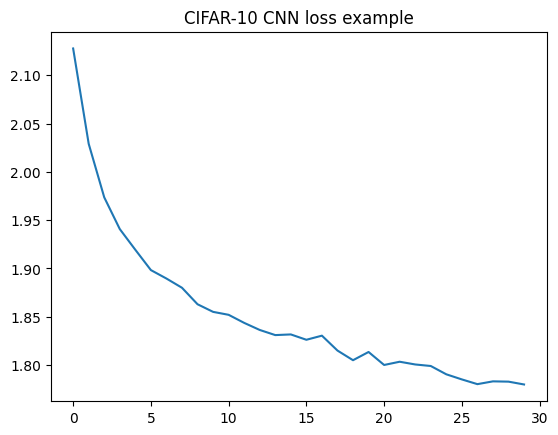

In [10]:
plt.plot(total_loss)
plt.title("CIFAR-10 CNN loss example")
plt.show()